In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os, sys
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0,nb_path)

In [3]:
# !pip install feature_engine --target=$nb_path jdc

# 1 - Perkenalan

Nama: Bagus Tirta Aji Hakim

Batch: FTDS-018-RMT

Dataset: Churn Customer

Objective: Memprediksi customer yang akan Churn atau Tidak Churn

Column | Description
----- | -----
`user_id` | ID of a customer
`age` | Age of a customer
`gender` | Gender of a customer
`region_category` | Region that a customer belongs to
`membership_category` | Category of the membership that a customer is using
`joining_date` | Date when a customer became a member
`joined_through_referral` | Whether a customer joined using any referral code or ID
`preferred_offer_types` | Type of offer that a customer prefers
`medium_of_operation` | Medium of operation that a customer uses for transactions
`internet_option` | Type of internet service a customer uses
`last_visit_time` | The last time a customer visited the website
`days_since_last_login` | Number of days since a customer last logged into the website
`avg_time_spent` | Average time spent by a customer on the website
`avg_transaction_value` | Average transaction value of a customer
`avg_frequency_login_days` | 	Number of times a customer has logged in to the website
`points_in_wallet` | `used_special_discount` | Points awarded to a customer on each transaction
`offer_application_preference` | Whether a customer uses special discounts offered
`past_complaint` | Whether a customer prefers offers
`complaint_status` | Whether the complaints raised by a customer was resolved
`feedback` | Feedback provided by a customer
`churn_risk_score` | Churn score (`0`: Not Churn, `1`: Churn)

# 2 - Import Libraries

In [4]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import seaborn as sns
import tensorflow as tf
import pickle

# import jdc

from scipy.stats import shapiro
from feature_engine.outliers import Winsorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

from keras import backend as K
from tensorflow.keras import Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, concatenate

# 3 - Data Loading

In [5]:
data = pd.read_csv('/content/drive/MyDrive/Hacktiv8/phase2_dataset/churn.csv')
pd.set_option('display.max_columns', None)
data.head()

,user_id,age,gender,region_category,membership_category,joining_date,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,9f420209e7d129f3,29,F,NaN,No Membership,2017-04-05,Yes,Without Offers,NaN,Wi-Fi,22:29:49,4,1184.49,38604.69,10.0,627.48,Yes,Yes,Yes,No Information Available,Poor Website,1
1,ac6e97806267549e,50,M,NaN,Basic Membership,2017-03-31,Yes,Without Offers,Desktop,Fiber_Optic,15:44:56,11,338.15,7665.66,17.0,575.97,Yes,No,Yes,No Information Available,Poor Customer Service,1
2,a6aa19b1580eed4e,26,F,City,Silver Membership,2017-02-11,NaN,Credit/Debit Card Offers,NaN,Fiber_Optic,20:31:53,8,235.14,37671.69,5.0,767.93,Yes,No,Yes,No Information Available,Too many ads,0
3,aeee343277211c2f,63,F,Village,No Membership,2015-12-23,No,Credit/Debit Card Offers,Desktop,Fiber_Optic,14:28:05,10,56.67,15678.14,11.0,590.22,No,Yes,No,Not Applicable,Too many ads,1
4,82448b5c8ce6390c,64,M,Town,Silver Membership,2015-03-20,NaN,Gift Vouchers/Coupons,Smartphone,Wi-Fi,04:16:48,9,153.99,8422.68,0.0,722.04,Yes,No,No,Not Applicable,Poor Product Quality,0


In [6]:
data_duplicate = data.copy()

In [7]:
data.shape

(37010, 22)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37010 entries, 0 to 37009
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   user_id                       37010 non-null  object 
 1   age                           37010 non-null  int64  
 2   gender                        36951 non-null  object 
 3   region_category               31579 non-null  object 
 4   membership_category           37010 non-null  object 
 5   joining_date                  37010 non-null  object 
 6   joined_through_referral       31568 non-null  object 
 7   preferred_offer_types         36722 non-null  object 
 8   medium_of_operation           31615 non-null  object 
 9   internet_option               37010 non-null  object 
 10  last_visit_time               37010 non-null  object 
 11  days_since_last_login         37010 non-null  int64  
 12  avg_time_spent                37010 non-null  float64
 13  a

Analisa:
* Terdapat missing values di beberapa variabel
* Tipe data yang masih belum sesuai seperti `joining_date` dan `last_visit_time`
* Variabel yang tidak perlu dimasukkan dalam proses analisa hingga akhir yaitu `user_id`

In [9]:
data.describe()

,age,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,churn_risk_score
count,37010.000000,37010.000000,37010.000000,37010.000000,37010.000000,37010.000000,37010.000000
mean,37.120697,-41.943502,279.201356,29272.430216,14.659540,623.590885,0.540881
std,15.866834,228.875324,330.017336,19445.963492,9.478756,270.218956,0.498333
min,10.000000,-999.000000,0.000000,800.460000,0.000000,0.000000,0.000000
25%,23.000000,8.000000,60.122500,14177.835000,7.000000,574.220000,0.000000
50%,37.000000,12.000000,161.770000,27554.485000,14.000000,680.400000,1.000000
75%,51.000000,16.000000,356.525000,40858.672500,22.000000,756.990000,1.000000
max,64.000000,26.000000,3235.578521,99914.050000,73.061995,2069.069761,1.000000


Analisa sederhana:
* Rata-rata umur customer adalah 37 tahun, dengan umur paling tua yaitu 64 tahun dan paling muda umur 10 tahun
* Rata-rata transaksi yang dilakukan adalah 29,272 dengan transaksi terendah senilai 800 dan tertinggi senilai 99,914

## 3.1 - Preprocessing

In [10]:
# merubah tipe data object menjadi datetime

data["joining_date"] = pd.to_datetime(data["joining_date"])
data["last_visit_time"] = pd.to_datetime(data["last_visit_time"])

In [11]:
# mengambil nilai spesifik seperti jam, tahun, dan bulan

data['last_visit_time'] = pd.to_datetime(data['last_visit_time'], format='%H:%M').dt.hour
data['joining_year'] = pd.DatetimeIndex(data['joining_date']).year
data['joining_month'] = pd.DatetimeIndex(data['joining_date']).month

In [12]:
# merubah bulan yang nilainya berbentuk angka menjadi sebuah string, contoh: 1 menjadi Jan (January)

data['joining_month'] = data['joining_month'].apply(lambda x: calendar.month_abbr[x])

In [13]:
# mengubah integer menjadi object, karena joining year termasuk sebagai data kategorik

data['joining_year'] = data['joining_year'].astype(str)

In [14]:
# melakukan dropping kolom yang tidak digunakan dan melakukan rename column agar mudah diimplementasikan

data.drop(['user_id'], axis=1, inplace=True)
data.drop(['joining_date'], axis=1, inplace=True)
data.rename(columns = {'churn_risk_score':'churn'}, inplace = True)

In [15]:
data.head()

,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn,joining_year,joining_month
0,29,F,NaN,No Membership,Yes,Without Offers,NaN,Wi-Fi,22,4,1184.49,38604.69,10.0,627.48,Yes,Yes,Yes,No Information Available,Poor Website,1,2017,Apr
1,50,M,NaN,Basic Membership,Yes,Without Offers,Desktop,Fiber_Optic,15,11,338.15,7665.66,17.0,575.97,Yes,No,Yes,No Information Available,Poor Customer Service,1,2017,Mar
2,26,F,City,Silver Membership,NaN,Credit/Debit Card Offers,NaN,Fiber_Optic,20,8,235.14,37671.69,5.0,767.93,Yes,No,Yes,No Information Available,Too many ads,0,2017,Feb
3,63,F,Village,No Membership,No,Credit/Debit Card Offers,Desktop,Fiber_Optic,14,10,56.67,15678.14,11.0,590.22,No,Yes,No,Not Applicable,Too many ads,1,2015,Dec
4,64,M,Town,Silver Membership,NaN,Gift Vouchers/Coupons,Smartphone,Wi-Fi,4,9,153.99,8422.68,0.0,722.04,Yes,No,No,Not Applicable,Poor Product Quality,0,2015,Mar


In [16]:
data.dtypes

age                               int64
gender                           object
region_category                  object
membership_category              object
joined_through_referral          object
preferred_offer_types            object
medium_of_operation              object
internet_option                  object
last_visit_time                   int64
days_since_last_login             int64
avg_time_spent                  float64
avg_transaction_value           float64
avg_frequency_login_days        float64
points_in_wallet                float64
used_special_discount            object
offer_application_preference     object
past_complaint                   object
complaint_status                 object
feedback                         object
churn                             int64
joining_year                     object
joining_month                    object
dtype: object

# 4 - Exploratory Data Analysis

## 4.1 - Distribusi Data

In [17]:
# Get Numerical Columns and Categorical Columns

num_columns = data.select_dtypes(include=np.number).columns.tolist()
cat_columns = data.select_dtypes(include=['object']).columns.tolist()

print('Numerical Columns : ', num_columns)
print('Categorical Columns : ', cat_columns)

Numerical Columns :  ['age', 'last_visit_time', 'days_since_last_login', 'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days', 'points_in_wallet', 'churn']
Categorical Columns :  ['gender', 'region_category', 'membership_category', 'joined_through_referral', 'preferred_offer_types', 'medium_of_operation', 'internet_option', 'used_special_discount', 'offer_application_preference', 'past_complaint', 'complaint_status', 'feedback', 'joining_year', 'joining_month']


In [18]:
data_num = data[num_columns]
data_cat = data[cat_columns]

In [19]:
# cek distribusi data

normal = []
not_normal = []

def getDataDistribution(df, column):
    stat, p = shapiro(df[column])

    # hasil uji normalitas
    alpha = 0.05
    if p > alpha:
        normal.append((column))
        # print("Data terdistribusi normal")
    else:
        not_normal.append((column))
        # print("Data tidak terdistribusi normal")

In [20]:
for column in data_num:
    getDataDistribution(data_num, column)

print(normal)
print(not_normal)

[]
['age', 'last_visit_time', 'days_since_last_login', 'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days', 'points_in_wallet', 'churn']


/content/notebooks/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Berdasarkaan hasil uji normalitas menggunakan saphiro test, data numerik pada dataset tidak terdisribusi normal

## 4.2 - Check Cardinality

In [21]:
data_cat = data[cat_columns]

data_cat.nunique()

gender                           2
region_category                  3
membership_category              6
joined_through_referral          2
preferred_offer_types            3
medium_of_operation              3
internet_option                  3
used_special_discount            2
offer_application_preference     2
past_complaint                   2
complaint_status                 5
feedback                         9
joining_year                     3
joining_month                   12
dtype: int64

Menurut penliti, tingkat cardinality pada dataset telah dilalukan preprocessing masih dianggap wajar sehingga masih belum diperlukan untuk melakukan perlakukan khusus pada data kategorik tersebut.

## 4.2 - Visualisasi

> Melihat kesimbangan data

([<matplotlib.patches.Wedge at 0x7f68b2f9b520>,
 [Text(-0.14088605192229783, 1.090940475174401, 'Not Churn'),
  Text(0.1408861540635161, -1.090940461983692, 'Churn')],
 [Text(-0.07684693741216245, 0.5950584410042187, '54.1%'),
  Text(0.07684699312555422, -0.5950584338092865, '45.9%')])

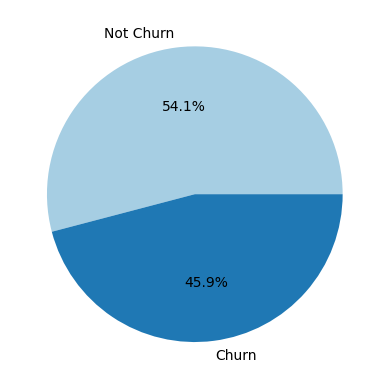

In [22]:
plt.pie(data.churn.value_counts(), labels = ["Not Churn", "Churn"], colors = sns.color_palette("Paired"), autopct = '%1.1f%%')

Berdasarkan pie chart, dapat dipastikan bahwa data yang digunakan telah balance sehingga tidak perlu dilakukan balancing data dan siap digunakan untuk melakukan tahap selanjutnya.

> Age terhadap Churn

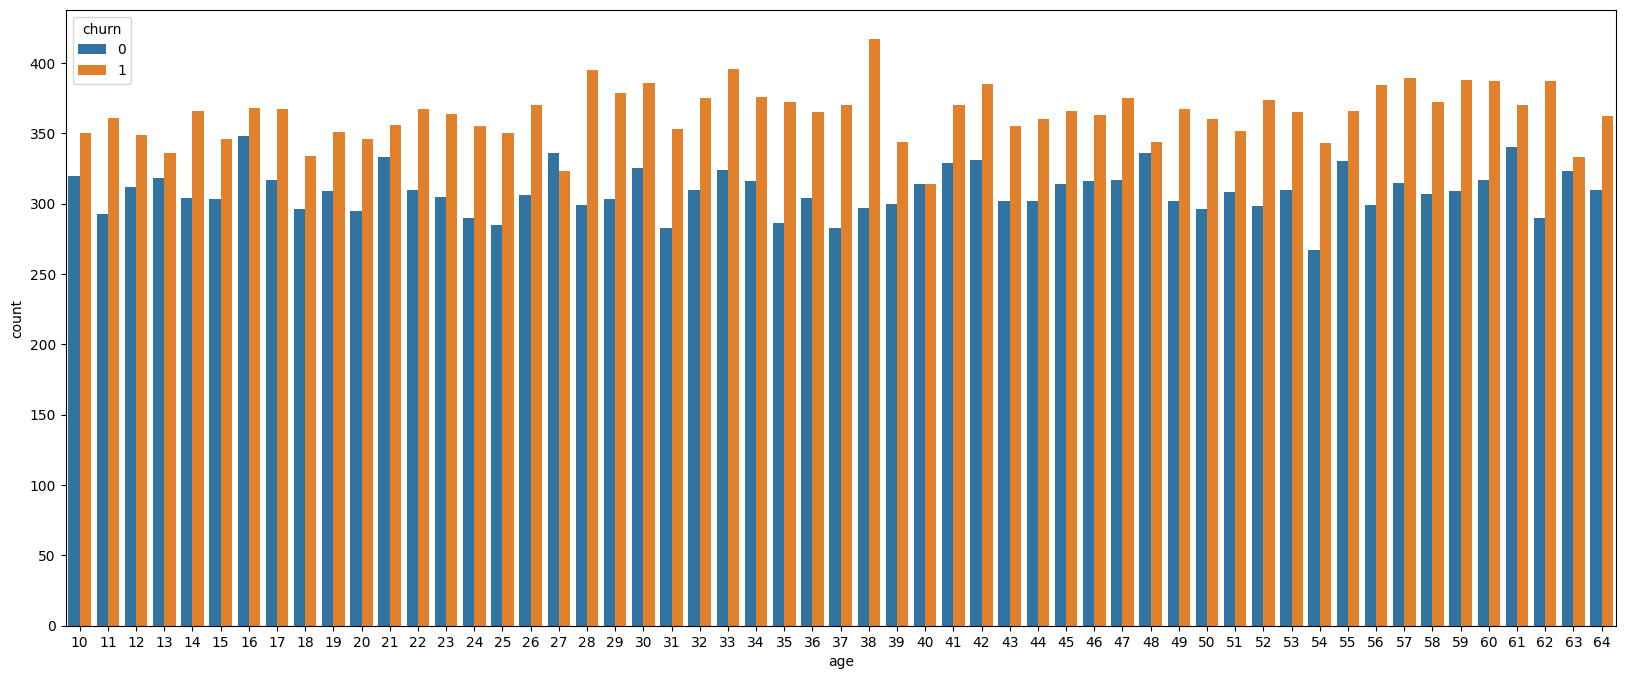

In [35]:
plt.figure(figsize = (20,8))

sns.countplot(data = data, x = 'age', hue = 'churn')
plt.show()

Umur customer terdistribusi secara merata dari umur 10 tahun hingga 64 tahun dimana tingkat churn tertinggi terjadi pada customer yang berumur 38 tahun.

> Complaint Status terhadap Churn

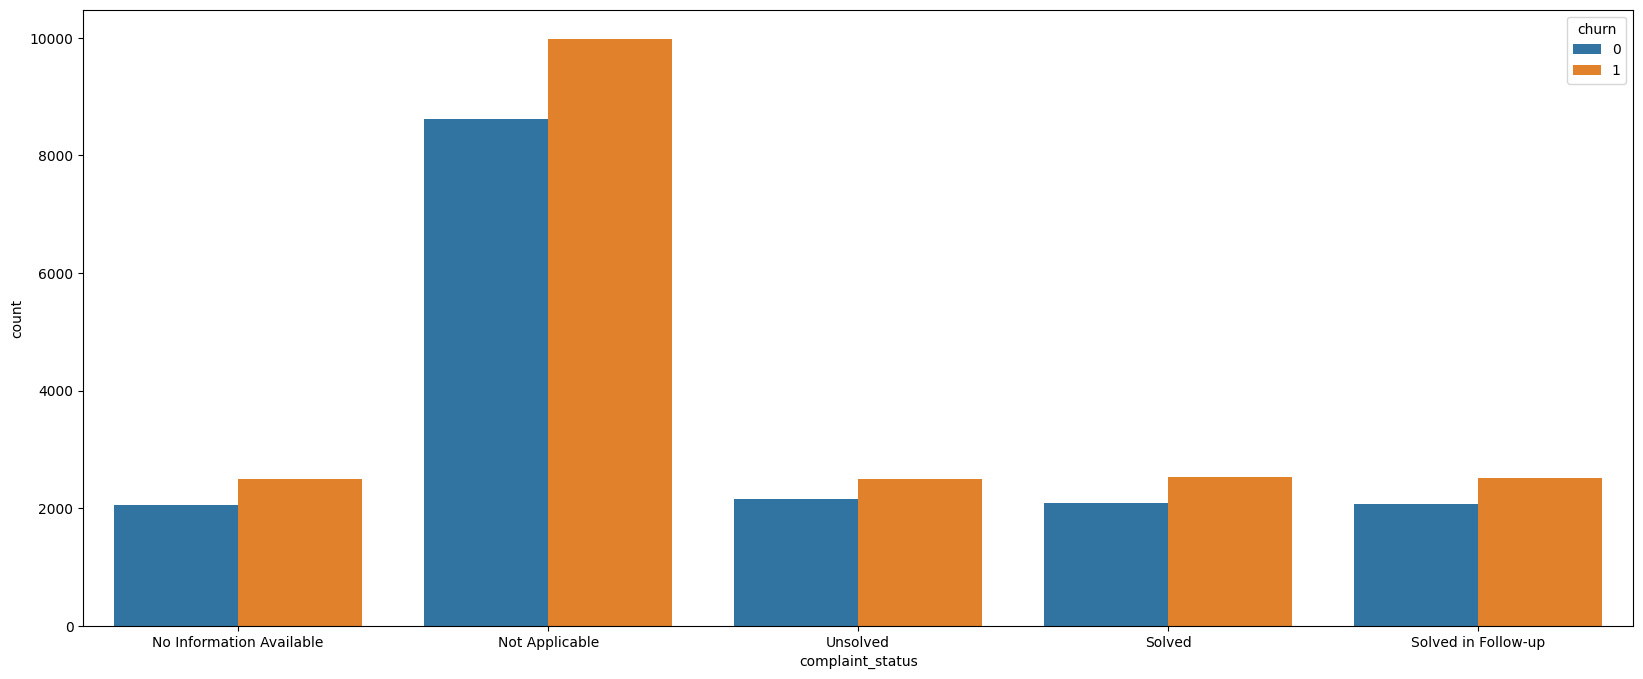

In [46]:
plt.figure(figsize = (20,8))

sns.countplot(data = data, x = 'complaint_status', hue = 'churn')
plt.show()

Berdasarkan grafik, peneliti dapat menyimpulkan jika status complaint yang Not Applicable lebih mendominasi dibandingkan status complaint lainnya. Hal ini tentunya menjadi sebuah pekerjaan rumah bagi perusahaan untuk memperbaiki layanannya agar bagaimana complaint yang disampaikan oleh customer dapat terselesaikan dengan baik.

Kenapa? karena jika dilihat kembali pada status complaint yang Not Applicable juga memiliki tingkat churn yang lebih tinggi dibandingkan status complaint yang lain.

> Feedback terhadap Churn

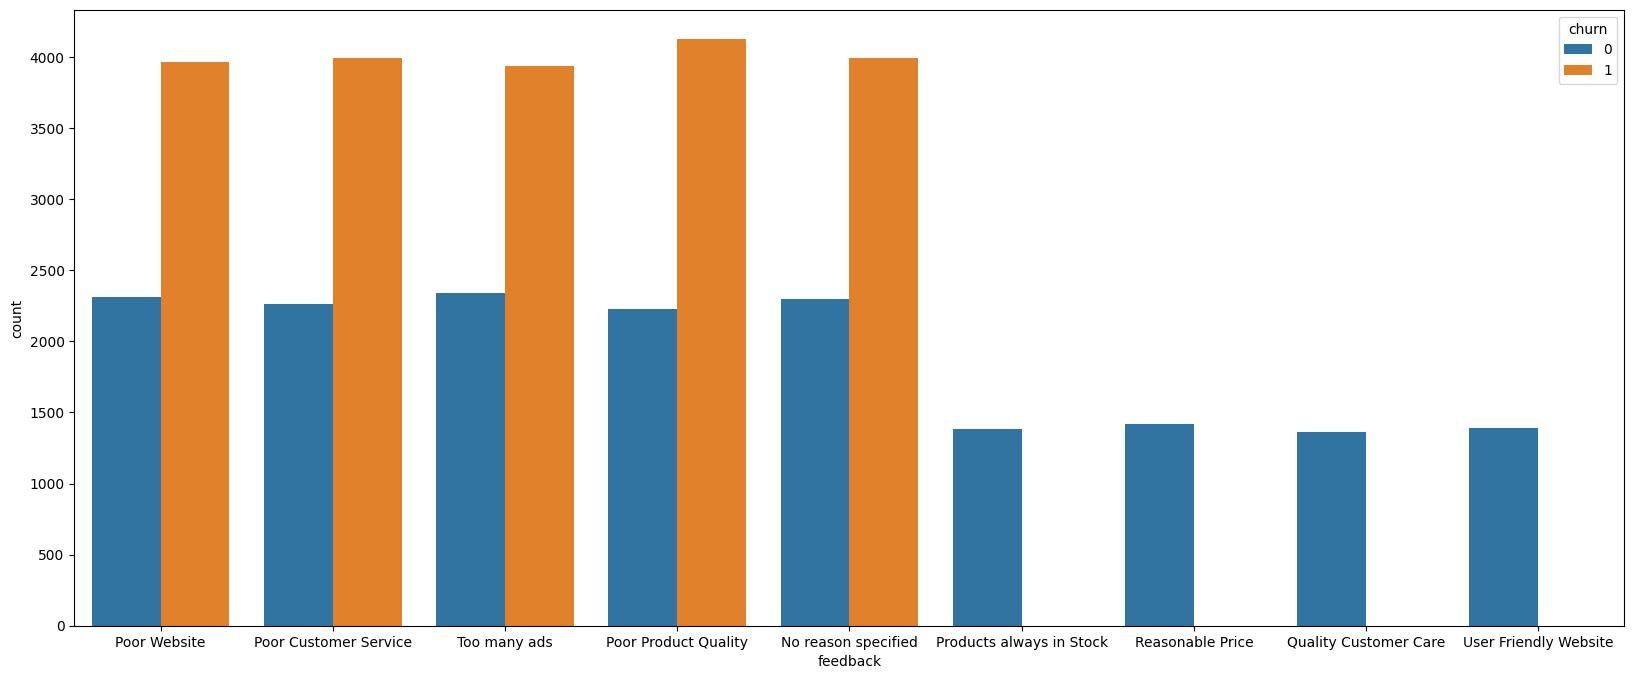

In [42]:
plt.figure(figsize = (20,8))

sns.countplot(data = data, x = 'feedback', hue = 'churn')
plt.show()             

Kemudian ternyata, potensi customer yang akan churn akan banyak terjadi jika terjadi beberapa hal berikut:

1. Dari website perusahaan yang mungkin sulit digunakan oleh customer untuk melakukan pembelian atau bisa jadi tampilan website yang sudah jadul sehingga mengurangi minat customer untuk tidak belanja di perusahaan tersebut.
2. Buruknya customer service dalam melayani customer, hal ini berhubungan dengan status complaint Not Applicable yang berarti complaint yang disampaikan oleh customer tidak tersampaikan dengan baik oleh customer service
3. Banyaknya tampilan iklan pada website yang mana juga berhubungan dengan poin nomor 1
4. Kualitas produk yang buruk sehingga perusahaan perlu melakukan evaluasi kembali mengenai produk yang telah dirilis.

# 5 - Feature Engineering

## 5.1 - Split X dan y

In [ ]:
X = data.drop(columns=['churn'])
y = data[['churn']]

## 5.2 - Split between Train, Validation, and Test

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=28)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=28)

print('Train Size : ', X_train.shape)
print('Val Size : ', X_val.shape)
print('Test Size : ', X_test.shape)

Train Size :  (26739, 21)
Val Size :  (4719, 21)
Test Size :  (5552, 21)


## 5.3 - Get Categorical and Numerical

In [ ]:
# Get Numerical Columns and Categorical Columns

num_columns = X_train.select_dtypes(include=np.number).columns.tolist()
cat_columns = X_train.select_dtypes(include=['object']).columns.tolist()

print('Numerical Columns : ', num_columns)
print('Categorical Columns : ', cat_columns)

Numerical Columns :  ['age', 'last_visit_time', 'days_since_last_login', 'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days', 'points_in_wallet']
Categorical Columns :  ['gender', 'region_category', 'membership_category', 'joined_through_referral', 'preferred_offer_types', 'medium_of_operation', 'internet_option', 'used_special_discount', 'offer_application_preference', 'past_complaint', 'complaint_status', 'feedback', 'joining_year', 'joining_month']


In [ ]:
X_train_num = X_train[num_columns]
X_test_num = X_test[num_columns]
X_val_num = X_val[num_columns]

X_train_cat = X_train[cat_columns]
X_test_cat = X_test[cat_columns]
X_val_cat = X_val[cat_columns]

In [ ]:
print('X_train_num shape:', X_train_num.shape)
print('X_test_num shape:', X_test_num.shape)
print('X_val_num shape:', X_train_num.shape)

X_train_num shape: (26739, 7)
X_test_num shape: (5552, 7)
X_val_num shape: (26739, 7)


## 5.4 - Outlier Handling

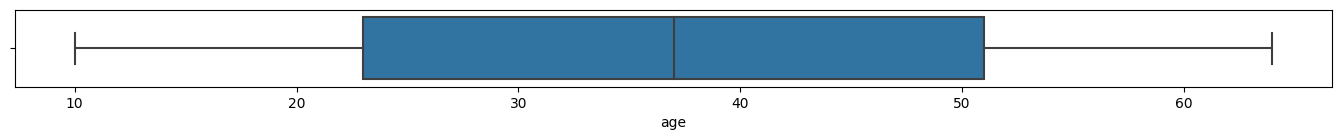

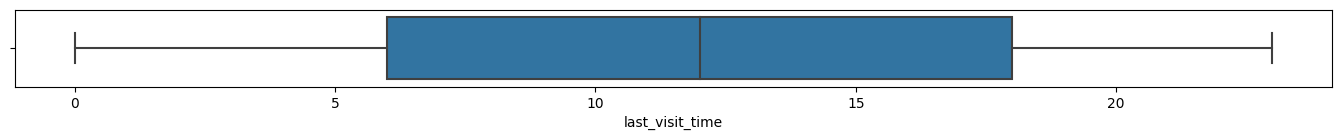

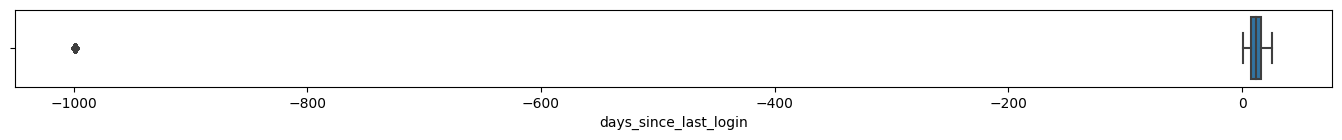

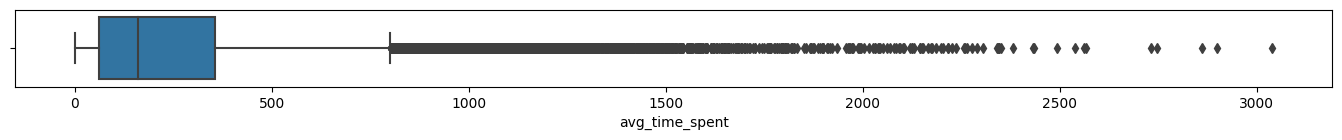

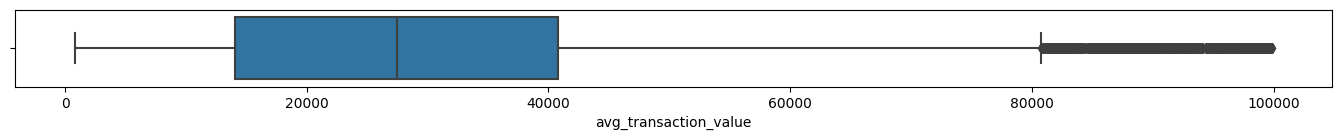

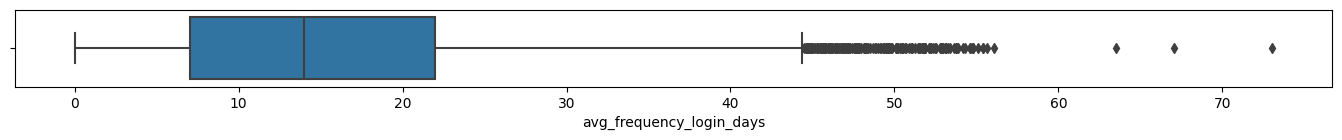

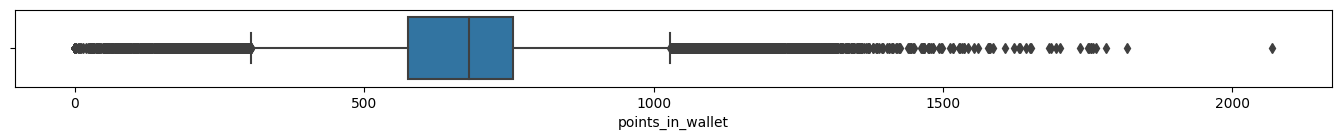

In [ ]:
# Check outliers with Boxplot

for column in X_train_num:
        plt.figure(figsize=(17,1))
        sns.boxplot(data=X_train_num, x=column)

> **Capping Outliers**

Pada kasus kali ini, outliers perlu dilakukan handling karena peneliti akan menggunakan pemodelan deep learning menggunakan Artificial Neural Network yang sensitif dengan outliers. 

Teknik yang dipilih adalah capping karena berdasarkan pada visualisasi di boxplot terdapat banyak outliers di tiap variabel-nya yang masih ingin dipertahankan oleh peneliti agar tidak kehilangan data yang sangat banyak.


In [ ]:
# Create the for left tail

windsoriser_left = Winsorizer(capping_method='iqr', # choose iqr for IQR rule boundaries or gaussian for mean and std
                              tail='left', # cap left, right or both tails 
                              fold=1.5,
                              variables=['days_since_last_login'])

windsoriser_left.fit(X_train_num)

X_train_num = windsoriser_left.transform(X_train_num)
X_test_num = windsoriser_left.transform(X_test_num)
X_val_num = windsoriser_left.transform(X_val_num)

In [ ]:
# Create the capper for right tail

windsoriser_right = Winsorizer(capping_method='iqr', # choose iqr for IQR rule boundaries or gaussian for mean and std
                              tail='right', # cap left, right or both tails 
                              fold=1.5,
                              variables=['avg_time_spent','avg_transaction_value','avg_frequency_login_days'])

windsoriser_right.fit(X_train_num)

X_train_num = windsoriser_right.transform(X_train_num)
X_test_num = windsoriser_right.transform(X_test_num)
X_val_num = windsoriser_right.transform(X_val_num)

In [ ]:
# Create the capper for both tail

windsoriser_both = Winsorizer(capping_method='iqr', # choose iqr for IQR rule boundaries or gaussian for mean and std
                              tail='both', # cap left, right or both tails 
                              fold=1.5,
                              variables=['points_in_wallet'])

windsoriser_both.fit(X_train_num)

X_train_num = windsoriser_both.transform(X_train_num)
X_test_num = windsoriser_both.transform(X_test_num)
X_val_num = windsoriser_both.transform(X_val_num)

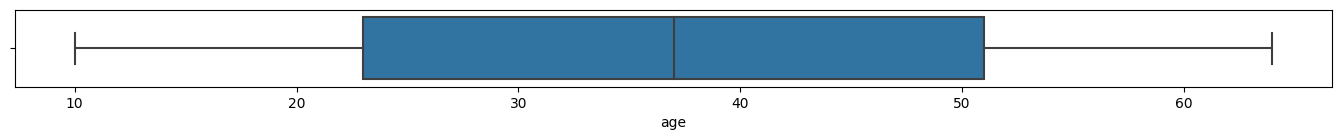

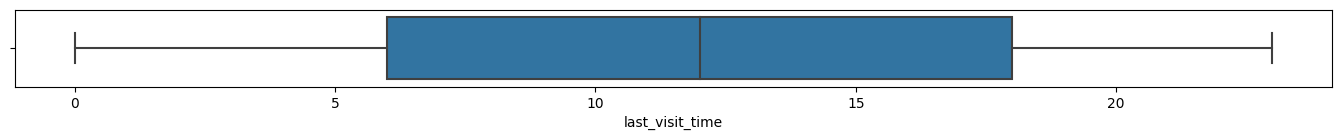

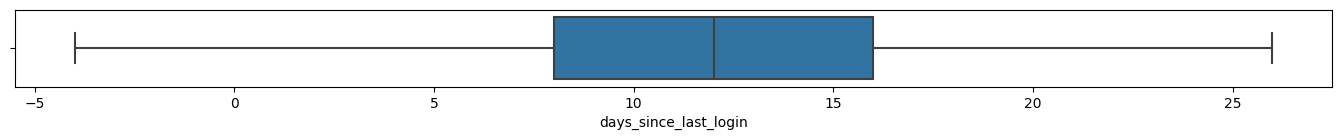

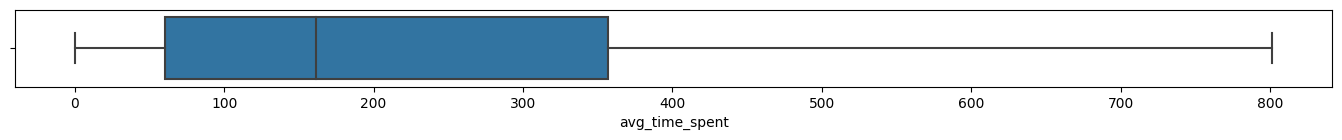

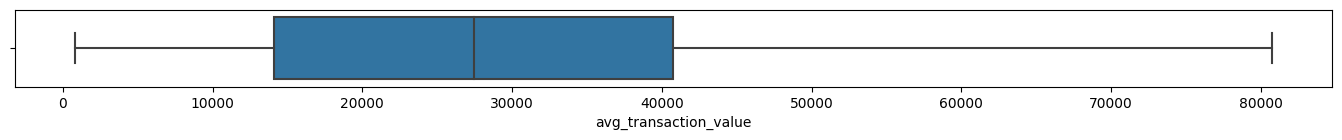

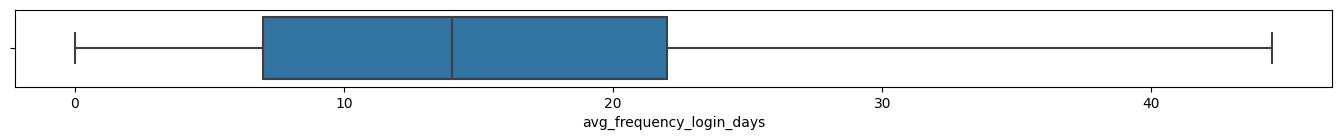

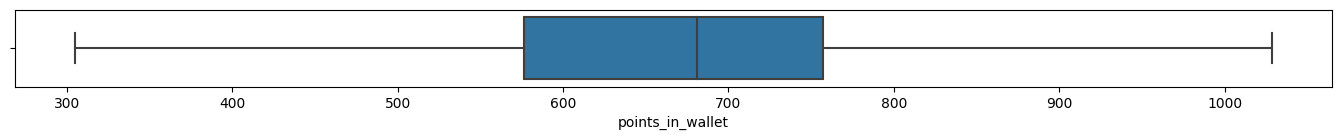

In [ ]:
# Check outliers after capping

for column in X_train_num:
        plt.figure(figsize=(17,1))
        sns.boxplot(data=X_train_num, x=column)

Data sudah terlihat bersih setelah dilakukan handling outlier dengan capping, sehingga data sudah siap digunakan untuk dilanjutkan ke tahap selanjutnya.

## 5.5 - Missing Values Handling

> Numeric Column

In [ ]:
X_train_num.isna().sum()

age                         0
last_visit_time             0
days_since_last_login       0
avg_time_spent              0
avg_transaction_value       0
avg_frequency_login_days    0
points_in_wallet            0
dtype: int64

In [ ]:
X_test_num.isna().sum()

age                         0
last_visit_time             0
days_since_last_login       0
avg_time_spent              0
avg_transaction_value       0
avg_frequency_login_days    0
points_in_wallet            0
dtype: int64

In [ ]:
X_val_num.isna().sum()

age                         0
last_visit_time             0
days_since_last_login       0
avg_time_spent              0
avg_transaction_value       0
avg_frequency_login_days    0
points_in_wallet            0
dtype: int64

Tidak ditemukan missing values pada data numerik.

> Categoric columns

In [ ]:
X_train_cat_missing = X_train_cat.isnull().sum().sort_values(ascending = False)
missing_percent = (X_train_cat.isnull().sum()/X_train_cat.isnull().count() * 100).sort_values(ascending = False)

missing_percent = pd.concat([X_train_cat_missing, missing_percent], axis=1, keys=["total missing","missing percent"])
missing_percent

,total missing,missing percent
joined_through_referral,3942,14.742511
medium_of_operation,3939,14.731291
region_category,3926,14.682673
preferred_offer_types,224,0.837728
gender,46,0.172033
membership_category,0,0.000000
internet_option,0,0.000000
used_special_discount,0,0.000000
offer_application_preference,0,0.000000
past_complaint,0,0.000000


In [ ]:
data[data['joined_through_referral'].isnull()].head()

,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn,joining_year,joining_month
2,26,F,City,Silver Membership,NaN,Credit/Debit Card Offers,NaN,Fiber_Optic,20,8,235.14,37671.69,5.0,767.93,Yes,No,Yes,No Information Available,Too many ads,0,2017,Feb
4,64,M,Town,Silver Membership,NaN,Gift Vouchers/Coupons,Smartphone,Wi-Fi,4,9,153.99,8422.68,0.0,722.04,Yes,No,No,Not Applicable,Poor Product Quality,0,2015,Mar
12,24,F,Village,Silver Membership,NaN,Without Offers,Smartphone,Mobile_Data,10,14,160.27,49607.97,20.0,0.00,No,Yes,Yes,Solved,Too many ads,1,2016,Apr
16,63,M,NaN,Silver Membership,NaN,Credit/Debit Card Offers,Smartphone,Mobile_Data,1,9,92.07,21395.38,26.0,667.71,No,Yes,No,Not Applicable,Too many ads,1,2015,Jun
19,40,M,City,No Membership,NaN,Without Offers,Desktop,Wi-Fi,23,9,119.12,4384.76,8.0,0.00,Yes,No,Yes,Solved,Too many ads,0,2015,May


In [ ]:
data[data['medium_of_operation'].isnull()].head()

,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn,joining_year,joining_month
0,29,F,NaN,No Membership,Yes,Without Offers,NaN,Wi-Fi,22,4,1184.490000,38604.69,10.0,627.48,Yes,Yes,Yes,No Information Available,Poor Website,1,2017,Apr
2,26,F,City,Silver Membership,NaN,Credit/Debit Card Offers,NaN,Fiber_Optic,20,8,235.140000,37671.69,5.0,767.93,Yes,No,Yes,No Information Available,Too many ads,0,2017,Feb
5,35,M,Town,Premium Membership,No,Credit/Debit Card Offers,NaN,Wi-Fi,14,20,1397.318999,29664.01,28.0,782.49,No,Yes,Yes,Unsolved,Poor Product Quality,0,2016,Aug
8,49,M,Town,Platinum Membership,Yes,Without Offers,NaN,Fiber_Optic,18,3,650.120000,81628.48,11.0,0.00,Yes,Yes,No,Not Applicable,Products always in Stock,0,2017,Apr
10,53,F,NaN,Basic Membership,Yes,Gift Vouchers/Coupons,NaN,Fiber_Optic,8,2,39.850000,24087.96,10.0,656.38,Yes,No,No,Not Applicable,No reason specified,1,2015,Sep


In [ ]:
data[data['region_category'].isnull()].head()

,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn,joining_year,joining_month
0,29,F,NaN,No Membership,Yes,Without Offers,NaN,Wi-Fi,22,4,1184.49,38604.69,10.0,627.480000,Yes,Yes,Yes,No Information Available,Poor Website,1,2017,Apr
1,50,M,NaN,Basic Membership,Yes,Without Offers,Desktop,Fiber_Optic,15,11,338.15,7665.66,17.0,575.970000,Yes,No,Yes,No Information Available,Poor Customer Service,1,2017,Mar
6,43,M,NaN,Gold Membership,Yes,Gift Vouchers/Coupons,Smartphone,Mobile_Data,15,11,416.30,13160.39,24.0,712.940000,Yes,No,No,Not Applicable,No reason specified,1,2017,Mar
10,53,F,NaN,Basic Membership,Yes,Gift Vouchers/Coupons,NaN,Fiber_Optic,8,2,39.85,24087.96,10.0,656.380000,Yes,No,No,Not Applicable,No reason specified,1,2015,Sep
13,33,M,NaN,No Membership,Yes,Gift Vouchers/Coupons,Desktop,Fiber_Optic,21,12,142.85,9854.95,15.0,1357.366572,No,Yes,No,Not Applicable,Poor Website,1,2016,Jan


In [ ]:
data[data['preferred_offer_types'].isnull()].head()

,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn,joining_year,joining_month
90,52,F,NaN,Basic Membership,Yes,NaN,Smartphone,Wi-Fi,23,-999,68.820000,28467.12,0.0,0.000000,Yes,No,No,Not Applicable,Poor Customer Service,1,2017,Apr
164,58,M,City,Silver Membership,No,NaN,NaN,Mobile_Data,0,-999,173.870000,1045.85,24.0,638.630000,No,Yes,No,Not Applicable,Too many ads,1,2017,Jul
171,47,F,Town,No Membership,No,NaN,Smartphone,Fiber_Optic,1,13,1033.552633,45197.88,7.0,626.870000,Yes,No,Yes,Solved in Follow-up,Poor Product Quality,1,2017,Jul
246,63,M,City,Gold Membership,Yes,NaN,Smartphone,Fiber_Optic,5,5,438.260000,21627.21,13.0,784.750000,Yes,No,Yes,No Information Available,Poor Website,0,2017,Aug
254,10,M,Town,Gold Membership,Yes,NaN,Desktop,Fiber_Optic,4,15,869.982709,29733.41,6.0,1216.180871,Yes,No,No,Not Applicable,Poor Website,0,2016,Jul


In [ ]:
data[data['gender'].isnull()].head()

,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn,joining_year,joining_month
22,54,NaN,City,Basic Membership,No,Gift Vouchers/Coupons,Smartphone,Mobile_Data,12,13,156.07,32463.61,16.0,639.820000,Yes,No,Yes,No Information Available,Poor Product Quality,1,2017,Mar
145,47,NaN,Town,Silver Membership,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,2,13,262.65,35934.73,19.0,784.300000,Yes,Yes,Yes,Solved,Poor Website,0,2015,Apr
728,40,NaN,City,Silver Membership,No,Without Offers,Desktop,Mobile_Data,10,14,333.25,21440.09,18.0,749.310000,Yes,No,No,Not Applicable,Products always in Stock,0,2017,Jan
2304,23,NaN,Village,Premium Membership,Yes,Gift Vouchers/Coupons,NaN,Wi-Fi,10,17,93.88,38875.53,22.0,1181.889841,Yes,No,Yes,Unsolved,Poor Website,0,2017,Oct
2586,41,NaN,City,No Membership,Yes,Without Offers,NaN,Fiber_Optic,14,13,52.11,28298.29,6.0,548.630000,No,Yes,Yes,Unsolved,Poor Product Quality,1,2016,Nov


In [ ]:
X_test_cat.isna().sum()

gender                            6
region_category                 813
membership_category               0
joined_through_referral         788
preferred_offer_types            33
medium_of_operation             786
internet_option                   0
used_special_discount             0
offer_application_preference      0
past_complaint                    0
complaint_status                  0
feedback                          0
joining_year                      0
joining_month                     0
dtype: int64

In [ ]:
X_val_cat.isna().sum()

gender                            7
region_category                 692
membership_category               0
joined_through_referral         712
preferred_offer_types            31
medium_of_operation             670
internet_option                   0
used_special_discount             0
offer_application_preference      0
past_complaint                    0
complaint_status                  0
feedback                          0
joining_year                      0
joining_month                     0
dtype: int64

**Kesimpulan Sederhana**

* Pada data numerik tidak ditemukan missing values.

* Berdasarkan analisa missing values pada tiap variable data kategorik, peneliti meyakini bahwa tidak ada indikasi bahwa missing values pada suatu varibale berhubungan dengan variable lainnya. Hal ini dikarenakan berdasarkan analisa peneliti, setiap variable memiliki probabilitas missing values yang sama sehingga dapat disebut sebagai MCAR (Missing Completely at Random).

## 5.6 - Concat Final set

In [ ]:
# Concat data

X_train_final = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_final = pd.concat([X_test_num, X_test_cat], axis=1)
X_val_final = pd.concat([X_val_num, X_val_cat], axis=1)

## 5.7 - Columns Transformer

In [ ]:
# Create A Pipeline

num_pipeline = make_pipeline(StandardScaler())

cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), # karena data adalah kategorik, maka strategi yang peneliti gunakan adalah most_frequent
                             OneHotEncoder())

final_pipeline = ColumnTransformer([
    ('pipe_num', num_pipeline, num_columns),
    ('pipe_cat', cat_pipeline, cat_columns)
])

In [ ]:
# Fit and Transform

X_train_final = final_pipeline.fit_transform(X_train_final)
X_test_final = final_pipeline.transform(X_test_final)
X_val_final = final_pipeline.transform(X_val_final)

## 5.8 - Tensorflow Pipeline

Membuat pipeline untuk jumlah batch dan shuffle

In [ ]:
train_pipe = tf.data.Dataset.from_tensor_slices((X_train_final,y_train)).batch(16).shuffle(100)
test_pipe = tf.data.Dataset.from_tensor_slices((X_test_final,y_test)).batch(16)
val_pipe = tf.data.Dataset.from_tensor_slices((X_val_final,y_val)).batch(16)

# 6 - Metrics Function

* Metrics yang akan digunakan adalah f1-score, namun karena Keras Model tidak memiliki metrics f1-score maka perlu membuat kustomisasi metrics yang nantinya dapat digunakan ketika melakukan training dataset.

* Mengapa f1-score? Hal ini dikarenakan peneliti ingin menurunkan jumlah false negative dan false positive dimana peneliti ingin menghindari customer yang terprediksi churn namun kenyataan tidak churn dan menghindari customer yang terprediksi tidak churn namun kenyataannya churn.

* Bagi peneliti, tentunya kedua hal tersebut berbahaya bagi perusahaan jika tidak dihindari, oleh karena itu peneliti ingin membantu perusahaan agar dapat mempertahankan customer yang tidak churn dan mengurangi customer yang berpotensi churn.

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# 7 - Sequential API

In [ ]:
# Clear Session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Model Definition

model_sequential_base = Sequential()
model_sequential_base.add(Dense(21, activation='relu', input_shape=(X_train_final.shape[1],))) # Hidden Layer 1
model_sequential_base.add(Dense(40, activation='relu')) # Hidden Layer 2
model_sequential_base.add(Dense(1, activation='sigmoid')) # Output Layer

# Compile
model_sequential_base.compile(loss='binary_crossentropy',
                              optimizer='adam',
                              metrics=[f1_m])

model_sequential_base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 21)                1365      
                                                                 
 dense_1 (Dense)             (None, 40)                880       
                                                                 
 dense_2 (Dense)             (None, 1)                 41        
                                                                 
Total params: 2,286
Trainable params: 2,286
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Model training

history_base = model_sequential_base.fit(train_pipe, epochs=30, validation_data=val_pipe)

Epoch 1/30
1672/1672 [==============================] - 5s 2ms/step - loss: 0.3088 - f1_m: 0.8473 - val_loss: 0.2744 - val_f1_m: 0.8677
Epoch 2/30
1672/1672 [==============================] - 4s 2ms/step - loss: 0.2548 - f1_m: 0.8706 - val_loss: 0.2729 - val_f1_m: 0.8570
Epoch 3/30
1672/1672 [==============================] - 4s 2ms/step - loss: 0.2471 - f1_m: 0.8832 - val_loss: 0.2644 - val_f1_m: 0.8929
Epoch 4/30
1672/1672 [==============================] - 3s 2ms/step - loss: 0.2400 - f1_m: 0.8998 - val_loss: 0.2613 - val_f1_m: 0.8831
Epoch 5/30
1672/1672 [==============================] - 4s 2ms/step - loss: 0.2328 - f1_m: 0.9076 - val_loss: 0.2498 - val_f1_m: 0.9098
Epoch 6/30
1672/1672 [==============================] - 3s 2ms/step - loss: 0.2105 - f1_m: 0.9187 - val_loss: 0.2091 - val_f1_m: 0.9217
Epoch 7/30
1672/1672 [==============================] - 3s 2ms/step - loss: 0.1801 - f1_m: 0.9273 - val_loss: 0.1931 - val_f1_m: 0.9244
Epoch 8/30
1672/1672 [==========================

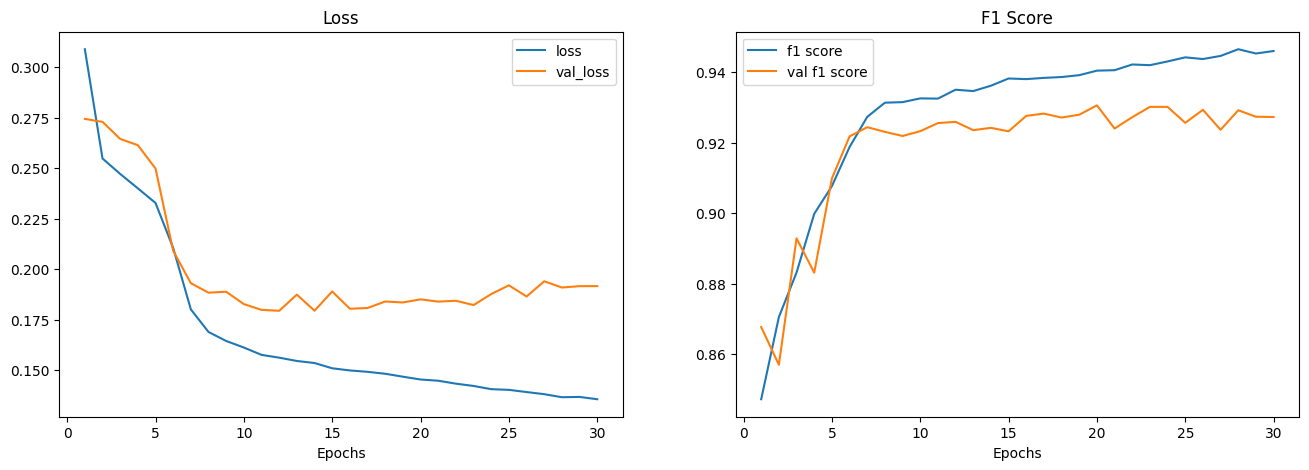

In [ ]:
epochs=30

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epochs+1),history_base.history['loss'],label='loss')
ax[0].plot(range(1,epochs+1),history_base.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')

ax[1].plot(range(1,epochs+1),history_base.history['f1_m'],label='f1 score')
ax[1].plot(range(1,epochs+1),history_base.history['val_f1_m'],label='val f1 score')
ax[1].set_title('F1 Score')
ax[1].legend()
ax[1].set_xlabel('Epochs')

plt.show()

* Berdasarkan hasil training dengan 16 batch dan shuffle sebanyak 100 dan menggunakan optimizer Adam, dapat dilihat pada grafik Loss bahwa pada data train dan data validation masih tergolong overfit dimana pada data validation grafik masih terus menaik sedangkan pada data train sudah signifikan menurun mendekati 0 serta terdapat exploding di sekitar epoch 12 - 15.

* Kemudian pada grafik f1-score, nilai train sudah berhasil meningkat dengan stabil dan berada di atas 0.95 namun pada nilai validation masih belum bisa meningkat seperti data train. Sehingga model ini masih belum memberikan perfrormansi terbaiknya dan perlu dilakukan improvement.

In [ ]:
y_pred_seq = model_sequential_base.predict(X_test_final)
y_pred_seq = np.where(y_pred_seq >= 0.5, 1, 0)

print(classification_report(y_test, y_pred_seq))

174/174 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2553
           1       0.93      0.94      0.93      2999

    accuracy                           0.93      5552
   macro avg       0.93      0.93      0.93      5552
weighted avg       0.93      0.93      0.93      5552



## 7.1 - Improvement 1

> **Add kernel_initializer**

In [ ]:
# Clear Session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
model_sequential_imp1 = Sequential()
model_sequential_imp1.add(Dense(21, activation='relu', input_shape=(X_train_final.shape[1],), kernel_initializer='HeNormal')) # Hidden Layer 1
model_sequential_imp1.add(Dense(40, activation='relu')) # Hidden Layer 2
model_sequential_imp1.add(Dense(1, activation='sigmoid')) # Output Layer

# Compile
model_sequential_imp1.compile(loss='binary_crossentropy',
                         optimizer='adam',
                         metrics=[f1_m])

model_sequential_imp1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 21)                1365      
                                                                 
 dense_1 (Dense)             (None, 40)                880       
                                                                 
 dense_2 (Dense)             (None, 1)                 41        
                                                                 
Total params: 2,286
Trainable params: 2,286
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_imp1 = model_sequential_imp1.fit(train_pipe, epochs=30, validation_data=val_pipe)

Epoch 1/30
1672/1672 [==============================] - 5s 2ms/step - loss: 0.3051 - f1_m: 0.8470 - val_loss: 0.2692 - val_f1_m: 0.8707
Epoch 2/30
1672/1672 [==============================] - 4s 2ms/step - loss: 0.2462 - f1_m: 0.8862 - val_loss: 0.2419 - val_f1_m: 0.9103
Epoch 3/30
1672/1672 [==============================] - 4s 3ms/step - loss: 0.2016 - f1_m: 0.9235 - val_loss: 0.1984 - val_f1_m: 0.9211
Epoch 4/30
1672/1672 [==============================] - 4s 2ms/step - loss: 0.1779 - f1_m: 0.9280 - val_loss: 0.1895 - val_f1_m: 0.9249
Epoch 5/30
1672/1672 [==============================] - 4s 2ms/step - loss: 0.1706 - f1_m: 0.9294 - val_loss: 0.1836 - val_f1_m: 0.9245
Epoch 6/30
1672/1672 [==============================] - 4s 2ms/step - loss: 0.1678 - f1_m: 0.9297 - val_loss: 0.1856 - val_f1_m: 0.9262
Epoch 7/30
1672/1672 [==============================] - 3s 2ms/step - loss: 0.1663 - f1_m: 0.9298 - val_loss: 0.1834 - val_f1_m: 0.9246
Epoch 8/30
1672/1672 [==========================

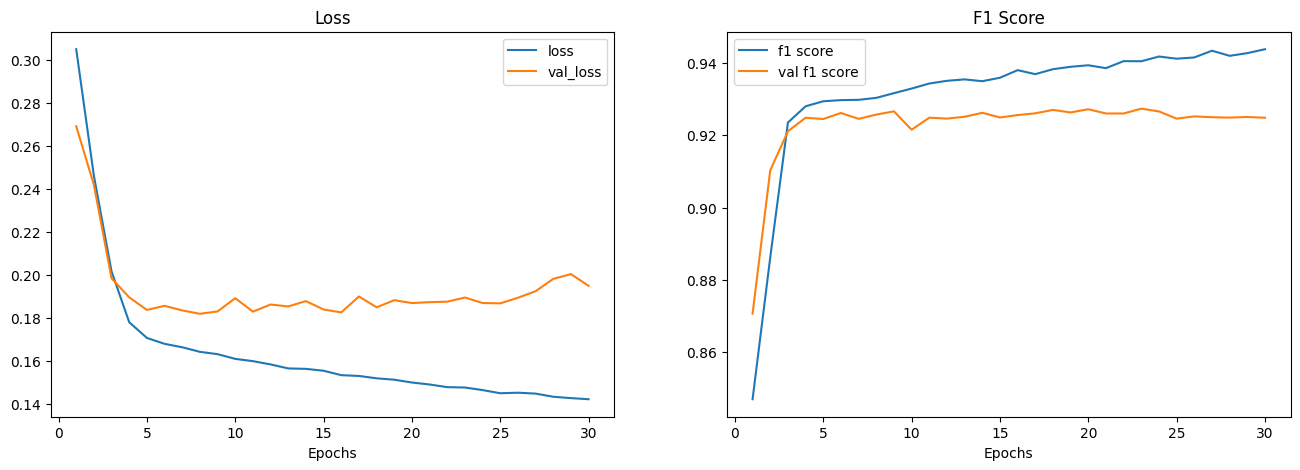

In [ ]:
epochs=30

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epochs+1),history_imp1.history['loss'],label='loss')
ax[0].plot(range(1,epochs+1),history_imp1.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')

ax[1].plot(range(1,epochs+1),history_imp1.history['f1_m'],label='f1 score')
ax[1].plot(range(1,epochs+1),history_imp1.history['val_f1_m'],label='val f1 score')
ax[1].set_title('F1 Score')
ax[1].legend()
ax[1].set_xlabel('Epochs')

plt.show()

Kali ini peneliti mencoba menambahkan weight initializer apakah terdapat peningkatan atau justru lebih tidak lebih baik dari model sebelumnya.

* Berdasarkan hasil training dengan 16 batch dan shuffle sebanyak 100 dan menggunakan optimizer **Adam** serta mengaktifkan initializer, dapat dilihat pada grafik Loss bahwa pada data train dan data validation masih tergolong overfit dimana pada data validation grafik masih terus menaik sedangkan pada data train sudah signifikan menurun mendekati 0.

* Kemudian pada grafik f1-score, nilai train sudah berhasil meningkat dengan stabil dan berada di atas 0.95 Kemudian pada nilai validation walau sudah stabil namun masih belum bisa meningkat seperti data train. Sehingga model ini masih belum memberikan perfrormansi terbaiknya dan perlu dilakukan improvement kembali.

In [ ]:
y_pred_seq = model_sequential_imp1.predict(X_test_final)
y_pred_seq = np.where(y_pred_seq >= 0.5, 1, 0)

print(classification_report(y_test, y_pred_seq))

174/174 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      2553
           1       0.92      0.95      0.93      2999

    accuracy                           0.93      5552
   macro avg       0.93      0.93      0.93      5552
weighted avg       0.93      0.93      0.93      5552



## 7.2 - Improvement 2

> Using Nadam optimizer

In [ ]:
# Clear Session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Model Definition

model_sequential_imp2 = Sequential()
model_sequential_imp2.add(Dense(21, activation='relu', input_shape=(X_train_final.shape[1],))) # Hidden Layer 1
model_sequential_imp2.add(Dense(40, activation='relu')) # Hidden Layer 2
model_sequential_imp2.add(Dense(1, activation='sigmoid')) # Output Layer

# Compile
model_sequential_imp2.compile(loss='binary_crossentropy',
                         optimizer='nadam',
                         metrics=[f1_m])

model_sequential_imp2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 21)                1365      
                                                                 
 dense_1 (Dense)             (None, 40)                880       
                                                                 
 dense_2 (Dense)             (None, 1)                 41        
                                                                 
Total params: 2,286
Trainable params: 2,286
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Model training

history_imp2 = model_sequential_imp2.fit(train_pipe, epochs=30, validation_data=val_pipe)

Epoch 1/30
1672/1672 [==============================] - 5s 2ms/step - loss: 0.3062 - f1_m: 0.8517 - val_loss: 0.2692 - val_f1_m: 0.8685
Epoch 2/30
1672/1672 [==============================] - 5s 3ms/step - loss: 0.2526 - f1_m: 0.8724 - val_loss: 0.2666 - val_f1_m: 0.8750
Epoch 3/30
1672/1672 [==============================] - 6s 3ms/step - loss: 0.2452 - f1_m: 0.8843 - val_loss: 0.2541 - val_f1_m: 0.8952
Epoch 4/30
1672/1672 [==============================] - 4s 2ms/step - loss: 0.2124 - f1_m: 0.9182 - val_loss: 0.2073 - val_f1_m: 0.9226
Epoch 5/30
1672/1672 [==============================] - 4s 2ms/step - loss: 0.1797 - f1_m: 0.9292 - val_loss: 0.1916 - val_f1_m: 0.9266
Epoch 6/30
1672/1672 [==============================] - 5s 3ms/step - loss: 0.1687 - f1_m: 0.9322 - val_loss: 0.1840 - val_f1_m: 0.9244
Epoch 7/30
1672/1672 [==============================] - 4s 2ms/step - loss: 0.1647 - f1_m: 0.9324 - val_loss: 0.1865 - val_f1_m: 0.9275
Epoch 8/30
1672/1672 [==========================

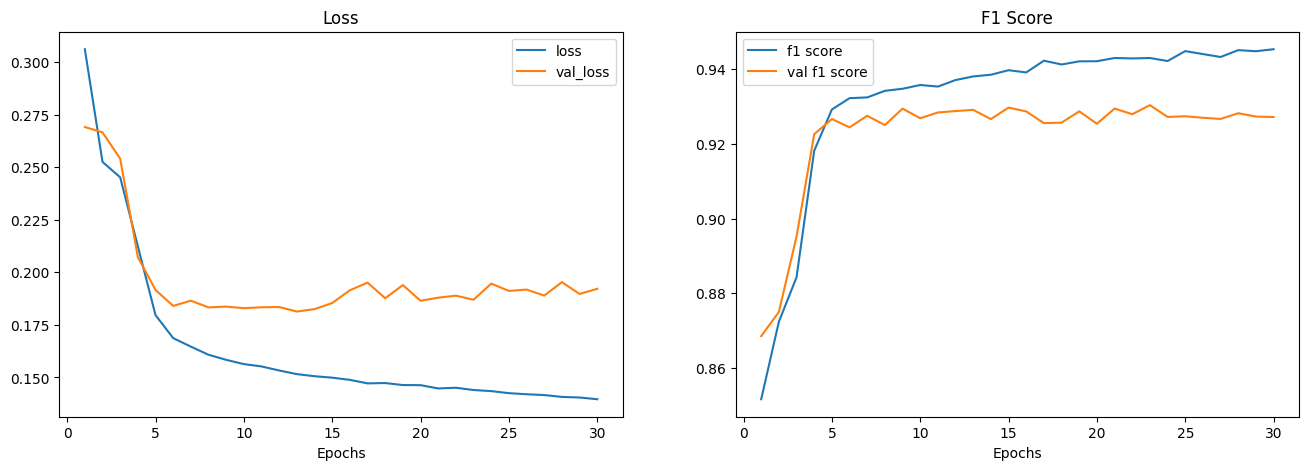

In [ ]:
epochs=30

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epochs+1),history_imp2.history['loss'],label='loss')
ax[0].plot(range(1,epochs+1),history_imp2.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')

ax[1].plot(range(1,epochs+1),history_imp2.history['f1_m'],label='f1 score')
ax[1].plot(range(1,epochs+1),history_imp2.history['val_f1_m'],label='val f1 score')
ax[1].set_title('F1 Score')
ax[1].legend()
ax[1].set_xlabel('Epochs')

plt.show()

Kali ini peneliti mencoba menghilangkan weight initializer apakah terdapat peningkatan atau justru lebih tidak lebih baik dari model sebelumnya.

* Berdasarkan hasil training dengan 16 batch dan shuffle sebanyak 100 dan menggunakan optimizer **Nadam**, dapat dilihat pada grafik Loss bahwa pada data train dan data validation masih tergolong overfit dimana pada data validation grafik masih terus menaik sedangkan pada data train sudah signifikan menurun mendekati 0.

* Kemudian pada grafik f1-score, nilai train sudah berhasil meningkat dengan stabil dan berada di atas 0.95 Kemudian pada nilai validation walau sudah stabil dan masih belum bisa meningkat seperti data train. Sehingga lagi-lagi model ini masih belum memberikan perfrormansi terbaiknya dan perlu dilakukan improvement kembali.

In [ ]:
y_pred_seq = model_sequential_imp2.predict(X_test_final)
y_pred_seq = np.where(y_pred_seq >= 0.5, 1, 0)

print(classification_report(y_test, y_pred_seq))

174/174 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      2553
           1       0.92      0.95      0.93      2999

    accuracy                           0.93      5552
   macro avg       0.93      0.92      0.93      5552
weighted avg       0.93      0.93      0.93      5552



## 7.3 - Improvement 3

> Using AdaMax optimizer

In [ ]:
# Clear Session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Model Definition

model_sequential_imp3 = Sequential()
model_sequential_imp3.add(Dense(21, activation='relu', input_shape=(X_train_final.shape[1],))) # Hidden Layer 1
model_sequential_imp3.add(Dense(40, activation='relu')) # Hidden Layer 2
model_sequential_imp3.add(Dense(1, activation='sigmoid')) # Output Layer

# Compile
model_sequential_imp3.compile(loss='binary_crossentropy',
                         optimizer='AdaMax',
                         metrics=[f1_m])

model_sequential_imp3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 21)                1365      
                                                                 
 dense_1 (Dense)             (None, 40)                880       
                                                                 
 dense_2 (Dense)             (None, 1)                 41        
                                                                 
Total params: 2,286
Trainable params: 2,286
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Model training

history_imp3 = model_sequential_imp3.fit(train_pipe, epochs=30, validation_data=val_pipe)

Epoch 1/30
1672/1672 [==============================] - 6s 2ms/step - loss: 0.3848 - f1_m: 0.8185 - val_loss: 0.2787 - val_f1_m: 0.8686
Epoch 2/30
1672/1672 [==============================] - 3s 2ms/step - loss: 0.2590 - f1_m: 0.8671 - val_loss: 0.2703 - val_f1_m: 0.8779
Epoch 3/30
1672/1672 [==============================] - 4s 3ms/step - loss: 0.2516 - f1_m: 0.8742 - val_loss: 0.2660 - val_f1_m: 0.8747
Epoch 4/30
1672/1672 [==============================] - 4s 2ms/step - loss: 0.2491 - f1_m: 0.8786 - val_loss: 0.2650 - val_f1_m: 0.8751
Epoch 5/30
1672/1672 [==============================] - 4s 2ms/step - loss: 0.2473 - f1_m: 0.8835 - val_loss: 0.2637 - val_f1_m: 0.8823
Epoch 6/30
1672/1672 [==============================] - 4s 2ms/step - loss: 0.2451 - f1_m: 0.8853 - val_loss: 0.2633 - val_f1_m: 0.8785
Epoch 7/30
1672/1672 [==============================] - 4s 2ms/step - loss: 0.2437 - f1_m: 0.8920 - val_loss: 0.2622 - val_f1_m: 0.8789
Epoch 8/30
1672/1672 [==========================

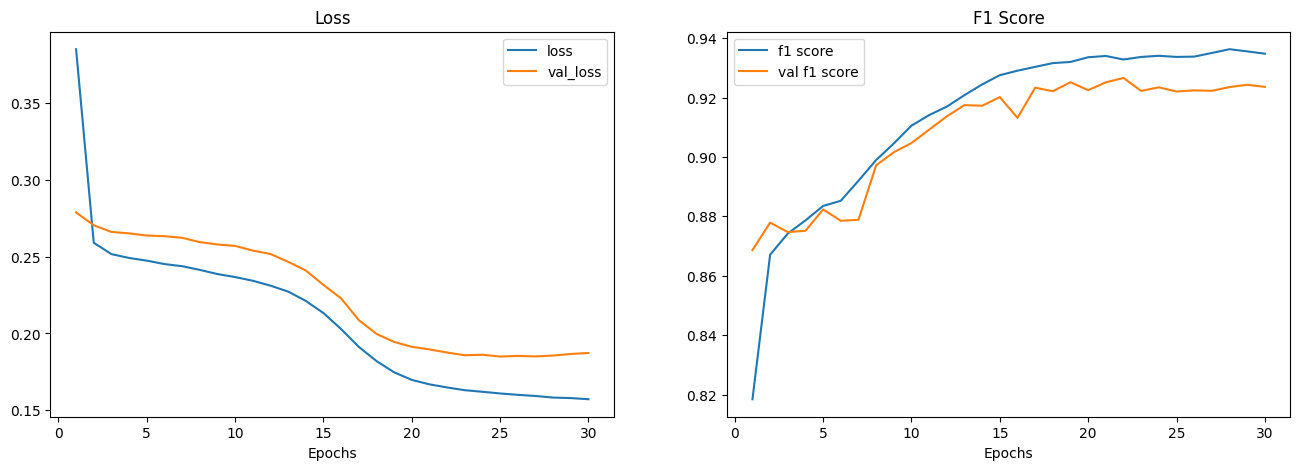

In [ ]:
epochs=30

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epochs+1),history_imp3.history['loss'],label='loss')
ax[0].plot(range(1,epochs+1),history_imp3.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')

ax[1].plot(range(1,epochs+1),history_imp3.history['f1_m'],label='f1 score')
ax[1].plot(range(1,epochs+1),history_imp3.history['val_f1_m'],label='val f1 score')
ax[1].set_title('F1 Score')
ax[1].legend()
ax[1].set_xlabel('Epochs')

plt.show()

Masih dengan cara yang sama yakni peneliti mencoba menghilangkan weight initializer apakah terdapat peningkatan atau justru lebih tidak lebih baik dari model sebelumnya.

* Berdasarkan hasil training dengan 16 batch dan shuffle sebanyak 100 dan menggunakan optimizer **AdaMax**, dapat dilihat pada grafik Loss bahwa pada data train dan data validation sudah lebih baik dan dapat dikatakan goodfit,  dimana pada data validation dan train sama-sama terjadi penurunan yang signifikan.

* Kemudian pada grafik f1-score, nilai train sudah berhasil meningkat dengan stabil dan berada di atas 0.92 Kemudian pada nilai validation pun sudah mulai berhasil mengikuti train dengan score juga di sekitar 0.92. Sehingga model dapat dikatakan goodfit dan model ini merupakan model terbaik daripada yang telah diuji sebelumnya.

In [ ]:
y_pred_seq = model_sequential_imp3.predict(X_test_final)
y_pred_seq = np.where(y_pred_seq >= 0.5, 1, 0)

print(classification_report(y_test, y_pred_seq))

174/174 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      2553
           1       0.91      0.95      0.93      2999

    accuracy                           0.92      5552
   macro avg       0.93      0.92      0.92      5552
weighted avg       0.92      0.92      0.92      5552



# 8 - Functional API

In [ ]:
# Clear Session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Create Functional Model

input_layer = Input(shape=(X_train_final.shape[1],))
hidden_layer_1 = Dense(21, activation='relu')(input_layer)
hidden_layer_2 = Dense(40, activation='relu')(hidden_layer_1)

concat_layer = concatenate([input_layer, hidden_layer_2])
output_layer = Dense(1, activation='sigmoid')(concat_layer)

model_functional_base = Model(inputs=input_layer, outputs=output_layer)

# Compile
model_functional_base.compile(loss='binary_crossentropy',
                              optimizer='adam',
                              metrics=f1_m)
model_functional_base.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 21)           1365        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 40)           880         ['dense[0][0]']                  
                                                                                                  
 concatenate (Concatenate)      (None, 104)          0           ['input_1[0][0]',                
                                                                  'dense_1[0][0]']            

In [ ]:
history_base = model_functional_base.fit(train_pipe, epochs=30, validation_data=val_pipe)

Epoch 1/30
1672/1672 [==============================] - 5s 2ms/step - loss: 0.3092 - f1_m: 0.8415 - val_loss: 0.2720 - val_f1_m: 0.8618
Epoch 2/30
1672/1672 [==============================] - 4s 2ms/step - loss: 0.2541 - f1_m: 0.8734 - val_loss: 0.2684 - val_f1_m: 0.8853
Epoch 3/30
1672/1672 [==============================] - 4s 2ms/step - loss: 0.2473 - f1_m: 0.8845 - val_loss: 0.2621 - val_f1_m: 0.8960
Epoch 4/30
1672/1672 [==============================] - 4s 2ms/step - loss: 0.2312 - f1_m: 0.9064 - val_loss: 0.2355 - val_f1_m: 0.9134
Epoch 5/30
1672/1672 [==============================] - 5s 3ms/step - loss: 0.1928 - f1_m: 0.9273 - val_loss: 0.2020 - val_f1_m: 0.9230
Epoch 6/30
1672/1672 [==============================] - 4s 2ms/step - loss: 0.1739 - f1_m: 0.9307 - val_loss: 0.1895 - val_f1_m: 0.9219
Epoch 7/30
1672/1672 [==============================] - 4s 2ms/step - loss: 0.1683 - f1_m: 0.9314 - val_loss: 0.1871 - val_f1_m: 0.9254
Epoch 8/30
1672/1672 [==========================

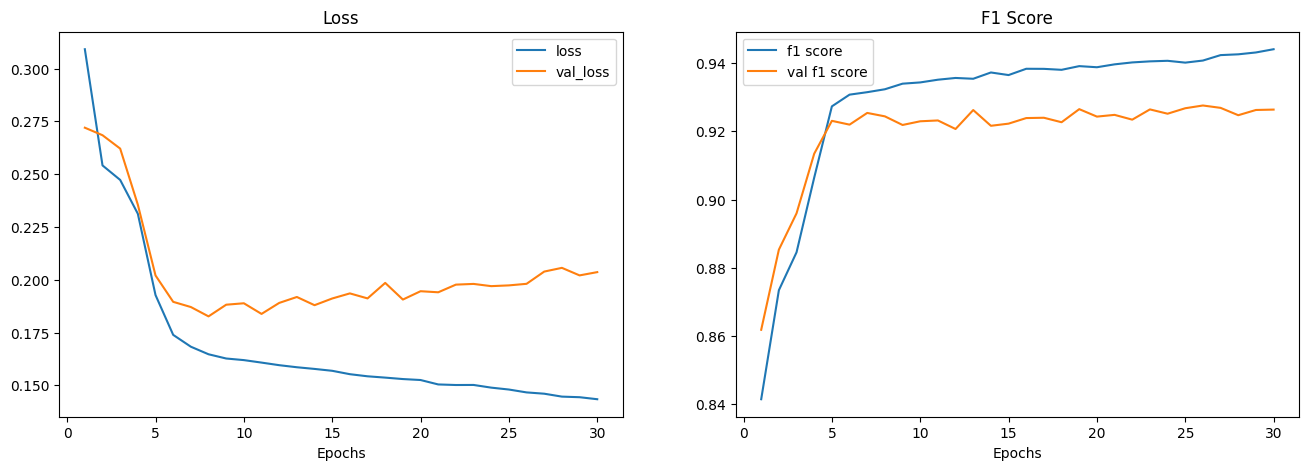

In [ ]:
epochs=30

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epochs+1),history_base.history['loss'],label='loss')
ax[0].plot(range(1,epochs+1),history_base.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')

ax[1].plot(range(1,epochs+1),history_base.history['f1_m'],label='f1 score')
ax[1].plot(range(1,epochs+1),history_base.history['val_f1_m'],label='val f1 score')
ax[1].set_title('F1 Score')
ax[1].legend()
ax[1].set_xlabel('Epochs')

plt.show()

* Berdasarkan hasil training dengan 16 batch dan shuffle sebanyak 100 dan menggunakan optimizer Adam serta tanpa mengaktifkan initializer, dapat dilihat pada grafik Loss bahwa pada data train dan data validation masih tergolong overfit dimana pada data validation grafik masih terus menaik sedangkan pada data train sudah signifikan menurun mendekati 0.

* Kemudian pada grafik f1-score, nilai train sudah berhasil meningkat dengan stabil dan berada di atas 0.95 Kemudian pada nilai validation walau sudah stabil namun masih belum bisa meningkat seperti data train. Sehingga model ini masih belum memberikan perfrormansi terbaiknya dan perlu dilakukan improvement kembali.

In [ ]:
y_pred_func = model_functional_base.predict(X_test_final)
y_pred_func = np.where(y_pred_func >= 0.5, 1, 0)

print(classification_report(y_test, y_pred_func))

174/174 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2553
           1       0.92      0.94      0.93      2999

    accuracy                           0.92      5552
   macro avg       0.92      0.92      0.92      5552
weighted avg       0.92      0.92      0.92      5552



## 8.1 - Improvement - 1

In [ ]:
# Clear Session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Create Functional Model

input_layer = Input(shape=(X_train_final.shape[1],))
hidden_layer_1 = Dense(21, activation='relu', kernel_initializer='HeNormal')(input_layer)
hidden_layer_2 = Dense(40, activation='relu')(hidden_layer_1)

concat_layer = concatenate([input_layer, hidden_layer_2])
output_layer = Dense(1, activation='sigmoid')(concat_layer)

model_functional = Model(inputs=input_layer, outputs=output_layer)

# Compile
model_functional.compile(loss='binary_crossentropy',
                         optimizer='adam',
                         metrics=f1_m)
model_functional.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 21)           1365        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 40)           880         ['dense[0][0]']                  
                                                                                                  
 concatenate (Concatenate)      (None, 104)          0           ['input_1[0][0]',                
                                                                  'dense_1[0][0]']            

In [ ]:
history = model_functional.fit(train_pipe, epochs=30, validation_data=val_pipe)

Epoch 1/30
1672/1672 [==============================] - 5s 2ms/step - loss: 0.3047 - f1_m: 0.8508 - val_loss: 0.2732 - val_f1_m: 0.8498
Epoch 2/30
1672/1672 [==============================] - 4s 3ms/step - loss: 0.2498 - f1_m: 0.8787 - val_loss: 0.2574 - val_f1_m: 0.8922
Epoch 3/30
1672/1672 [==============================] - 3s 2ms/step - loss: 0.2161 - f1_m: 0.9152 - val_loss: 0.2106 - val_f1_m: 0.9194
Epoch 4/30
1672/1672 [==============================] - 4s 2ms/step - loss: 0.1827 - f1_m: 0.9273 - val_loss: 0.1916 - val_f1_m: 0.9236
Epoch 5/30
1672/1672 [==============================] - 4s 3ms/step - loss: 0.1733 - f1_m: 0.9292 - val_loss: 0.1919 - val_f1_m: 0.9247
Epoch 6/30
1672/1672 [==============================] - 4s 2ms/step - loss: 0.1687 - f1_m: 0.9307 - val_loss: 0.1861 - val_f1_m: 0.9223
Epoch 7/30
1672/1672 [==============================] - 4s 2ms/step - loss: 0.1665 - f1_m: 0.9309 - val_loss: 0.1831 - val_f1_m: 0.9246
Epoch 8/30
1672/1672 [==========================

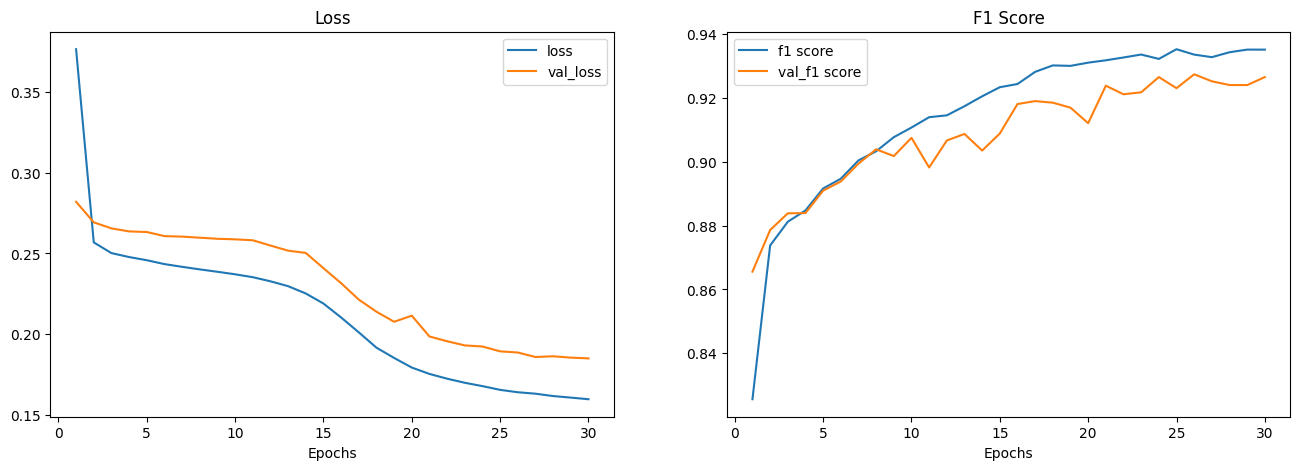

In [ ]:
epochs=30

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epochs+1),history.history['loss'],label='loss')
ax[0].plot(range(1,epochs+1),history.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')

ax[1].plot(range(1,epochs+1),history.history['f1_m'],label='f1 score')
ax[1].plot(range(1,epochs+1),history.history['val_f1_m'],label='val_f1 score')
ax[1].set_title('F1 Score')
ax[1].legend()
ax[1].set_xlabel('Epochs')

plt.show()

Disini peneliti mencoba pelakukan inisialisasi pada bobot dengan menggunakan HeNormal

* Berdasarkan hasil training dengan 16 batch dan shuffle sebanyak 100 dan menggunakan optimizer Adam serta mengaktifkan initializer, dapat dilihat pada grafik Loss bahwa pada data train dan data validation masih sudah cukup dikatakan goodfit dimana pada data validation dan train terus menurun mendekati 0.

* Namun pada grafik f1-score, nilai train sudah berhasil meningkat dengan stabil dan berada di atas 0.92 sedangkan pada nilai validation walau sudah stabil namun masih terdapat banyaknya exploding. Sehingga model ini masih belum memberikan perfrormansi terbaiknya dan perlu dilakukan improvement kembali.

In [ ]:
y_pred_seq = model_functional.predict(X_test_final)
y_pred_seq = np.where(y_pred_seq >= 0.5, 1, 0)

print(classification_report(y_test, y_pred_seq))

174/174 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2553
           1       0.94      0.93      0.93      2999

    accuracy                           0.93      5552
   macro avg       0.93      0.93      0.93      5552
weighted avg       0.93      0.93      0.93      5552



## 8.2 - Improvement - 2

In [ ]:
# Clear Session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Create Functional Model

input_layer = Input(shape=(X_train_final.shape[1],))
hidden_layer_1 = Dense(21, activation='relu')(input_layer)
hidden_layer_2 = Dense(40, activation='relu')(hidden_layer_1)

concat_layer = concatenate([input_layer, hidden_layer_2])
output_layer = Dense(1, activation='sigmoid')(concat_layer)

model_functional = Model(inputs=input_layer, outputs=output_layer)

# Compile
model_functional.compile(loss='binary_crossentropy',
                         optimizer='nadam',
                         metrics=f1_m)
model_functional.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 21)           1365        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 40)           880         ['dense[0][0]']                  
                                                                                                  
 concatenate (Concatenate)      (None, 104)          0           ['input_1[0][0]',                
                                                                  'dense_1[0][0]']            

In [ ]:
history = model_functional.fit(train_pipe, epochs=30, validation_data=val_pipe)

Epoch 1/30
1672/1672 [==============================] - 7s 3ms/step - loss: 0.3160 - f1_m: 0.8384 - val_loss: 0.2721 - val_f1_m: 0.8604
Epoch 2/30
1672/1672 [==============================] - 4s 2ms/step - loss: 0.2473 - f1_m: 0.8836 - val_loss: 0.2557 - val_f1_m: 0.8741
Epoch 3/30
1672/1672 [==============================] - 4s 2ms/step - loss: 0.2047 - f1_m: 0.9216 - val_loss: 0.2012 - val_f1_m: 0.9170
Epoch 4/30
1672/1672 [==============================] - 4s 3ms/step - loss: 0.1778 - f1_m: 0.9301 - val_loss: 0.1892 - val_f1_m: 0.9254
Epoch 5/30
1672/1672 [==============================] - 4s 2ms/step - loss: 0.1698 - f1_m: 0.9310 - val_loss: 0.1857 - val_f1_m: 0.9273
Epoch 6/30
1672/1672 [==============================] - 4s 2ms/step - loss: 0.1668 - f1_m: 0.9302 - val_loss: 0.1846 - val_f1_m: 0.9270
Epoch 7/30
1672/1672 [==============================] - 5s 3ms/step - loss: 0.1643 - f1_m: 0.9302 - val_loss: 0.1797 - val_f1_m: 0.9252
Epoch 8/30
1672/1672 [==========================

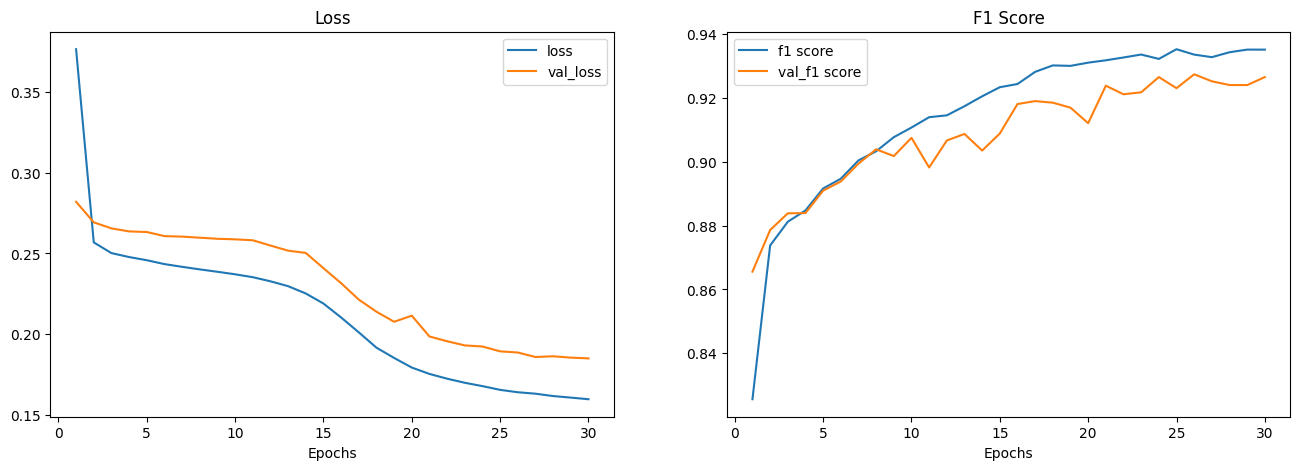

In [ ]:
epochs=30

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epochs+1),history.history['loss'],label='loss')
ax[0].plot(range(1,epochs+1),history.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')

ax[1].plot(range(1,epochs+1),history.history['f1_m'],label='f1 score')
ax[1].plot(range(1,epochs+1),history.history['val_f1_m'],label='val_f1 score')
ax[1].set_title('F1 Score')
ax[1].legend()
ax[1].set_xlabel('Epochs')

plt.show()

* Berdasarkan hasil training dengan 16 batch dan shuffle sebanyak 100 dan menggunakan optimizer **Nadam** serta tanpa mengaktifkan initializer, dapat dilihat pada grafik Loss bahwa pada data train dan data validation masih sudah dapat dikatakan sebagai model yang goodfit dimana pada data validation dan train menurun hingga mendekati 0.

* Kemudian pada grafik f1-score, nilai train sudah berhasil meningkat dengan stabil dan berada di atas 0.95 Kemudian pada nilai validation masih belum menunjukkan kestabilannya dan terdapat banyaknya exploding disitu. Sehingga model ini masih belum memberikan perfrormansi terbaiknya dan perlu dilakukan improvement kembali.

In [ ]:
y_pred_func = model_functional.predict(X_test_final)
y_pred_func = np.where(y_pred_func >= 0.5, 1, 0)

print(classification_report(y_test, y_pred_func))

174/174 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      2553
           1       0.91      0.95      0.93      2999

    accuracy                           0.92      5552
   macro avg       0.93      0.92      0.92      5552
weighted avg       0.92      0.92      0.92      5552



## 8.3 - Improvement - 3

In [ ]:
# Clear Session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Create Functional Model

input_layer = Input(shape=(X_train_final.shape[1],))
hidden_layer_1 = Dense(21, activation='relu')(input_layer)
hidden_layer_2 = Dense(40, activation='relu')(hidden_layer_1)

concat_layer = concatenate([input_layer, hidden_layer_2])
output_layer = Dense(1, activation='sigmoid')(concat_layer)

model_functional = Model(inputs=input_layer, outputs=output_layer)

# Compile
model_functional.compile(loss='binary_crossentropy',
                         optimizer='AdaMax',
                         metrics=f1_m)
model_functional.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 21)           1365        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 40)           880         ['dense[0][0]']                  
                                                                                                  
 concatenate (Concatenate)      (None, 104)          0           ['input_1[0][0]',                
                                                                  'dense_1[0][0]']            

In [ ]:
history = model_functional.fit(train_pipe, epochs=30, validation_data=val_pipe)

Epoch 1/30
1672/1672 [==============================] - 8s 3ms/step - loss: 0.3766 - f1_m: 0.8256 - val_loss: 0.2820 - val_f1_m: 0.8656
Epoch 2/30
1672/1672 [==============================] - 3s 2ms/step - loss: 0.2568 - f1_m: 0.8738 - val_loss: 0.2693 - val_f1_m: 0.8786
Epoch 3/30
1672/1672 [==============================] - 6s 4ms/step - loss: 0.2502 - f1_m: 0.8812 - val_loss: 0.2655 - val_f1_m: 0.8839
Epoch 4/30
1672/1672 [==============================] - 4s 2ms/step - loss: 0.2477 - f1_m: 0.8848 - val_loss: 0.2637 - val_f1_m: 0.8839
Epoch 5/30
1672/1672 [==============================] - 3s 2ms/step - loss: 0.2458 - f1_m: 0.8916 - val_loss: 0.2633 - val_f1_m: 0.8910
Epoch 6/30
1672/1672 [==============================] - 4s 3ms/step - loss: 0.2434 - f1_m: 0.8947 - val_loss: 0.2607 - val_f1_m: 0.8938
Epoch 7/30
1672/1672 [==============================] - 4s 2ms/step - loss: 0.2417 - f1_m: 0.9004 - val_loss: 0.2604 - val_f1_m: 0.8994
Epoch 8/30
1672/1672 [==========================

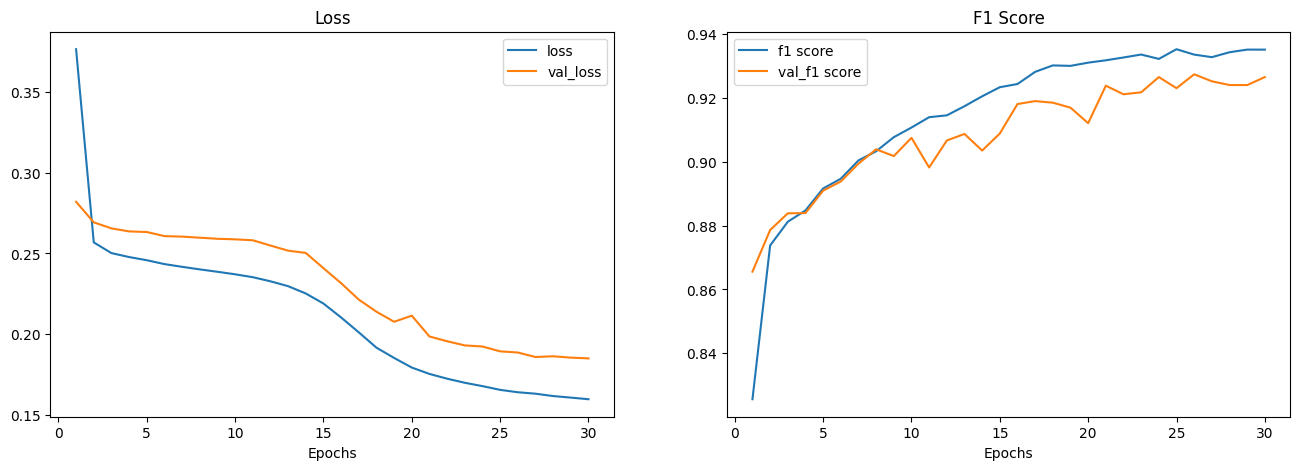

In [ ]:
epochs=30

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epochs+1),history.history['loss'],label='loss')
ax[0].plot(range(1,epochs+1),history.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')

ax[1].plot(range(1,epochs+1),history.history['f1_m'],label='f1 score')
ax[1].plot(range(1,epochs+1),history.history['val_f1_m'],label='val_f1 score')
ax[1].set_title('F1 Score')
ax[1].legend()
ax[1].set_xlabel('Epochs')

plt.show()

* Berdasarkan hasil training dengan 16 batch dan shuffle sebanyak 100 dan menggunakan optimizer **AdaMax** serta tanpa mengaktifkan initializer, dapat dilihat pada grafik Loss bahwa pada data train dan data validation masih sudah cukup dikatakan goodfit dimana pada data validation dan train terus menurun mendekati 0.

* Namun pada grafik f1-score, nilai train sudah berhasil meningkat dengan stabil dan berada di atas 0.92 sedangkan pada nilai validation walau sudah stabil namun masih terdapat banyaknya exploding. Sehingga model ini masih belum memberikan perfrormansi terbaiknya dan perlu dilakukan improvement kembali.

Hal ini sama halnya seperti pada penggunakan optimizer Nadam.

In [ ]:
y_pred_func = model_functional.predict(X_test_final)
y_pred_func = np.where(y_pred_func >= 0.5, 1, 0)

print(classification_report(y_test, y_pred_func))

174/174 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      2553
           1       0.91      0.95      0.93      2999

    accuracy                           0.92      5552
   macro avg       0.93      0.92      0.92      5552
weighted avg       0.92      0.92      0.92      5552



# 9 - Model Evaluation

> **Sequential API dengan Optimizer AdaMax**



In [ ]:
y_pred_seq_train = model_sequential_imp3.predict(X_train_final)
y_pred_seq_test = model_sequential_imp3.predict(X_test_final)

y_pred_seq_train = np.where(y_pred_seq_train >= 0.5, 1, 0)
y_pred_seq_test = np.where(y_pred_seq_test >= 0.5, 1, 0)

print('f1 score train set: %.3f' % f1_score(y_train, y_pred_seq_train))
print('f1 score train set: %.3f \n' % f1_score(y_test, y_pred_seq_test))
print(classification_report(y_train, y_pred_seq_train), '\n')
print(classification_report(y_test, y_pred_seq_test))

174/174 [==============================] - 1s 3ms/step
f1 score train set: 0.941
f1 score train set: 0.931 

              precision    recall  f1-score   support

           0       0.96      0.89      0.93     12273
           1       0.92      0.97      0.94     14466

    accuracy                           0.93     26739
   macro avg       0.94      0.93      0.93     26739
weighted avg       0.94      0.93      0.93     26739
 

              precision    recall  f1-score   support

           0       0.94      0.89      0.91      2553
           1       0.91      0.95      0.93      2999

    accuracy                           0.92      5552
   macro avg       0.93      0.92      0.92      5552
weighted avg       0.92      0.92      0.92      5552



> **Functional API dengan Optimizer AdaMax**

In [ ]:
y_pred_func_train = model_functional.predict(X_train_final)
y_pred_func_test = model_functional.predict(X_test_final)

y_pred_func_train = np.where(y_pred_func_train >= 0.5, 1, 0)
y_pred_func_test = np.where(y_pred_func_test >= 0.5, 1, 0)

print('f1 score train set: %.3f' % f1_score(y_train, y_pred_func_train))
print('f1 score train set: %.3f \n' % f1_score(y_test, y_pred_func_test))
print(classification_report(y_train, y_pred_func_train), '\n')
print(classification_report(y_test, y_pred_func_test))

174/174 [==============================] - 0s 1ms/step
f1 score train set: 0.941
f1 score train set: 0.931 

              precision    recall  f1-score   support

           0       0.96      0.90      0.93     12273
           1       0.92      0.97      0.94     14466

    accuracy                           0.93     26739
   macro avg       0.94      0.93      0.93     26739
weighted avg       0.94      0.93      0.93     26739
 

              precision    recall  f1-score   support

           0       0.94      0.89      0.91      2553
           1       0.91      0.95      0.93      2999

    accuracy                           0.92      5552
   macro avg       0.93      0.92      0.92      5552
weighted avg       0.92      0.92      0.92      5552



Sebagai perbandingan, peneliti mencoba mengambil model terbaik pada sequential API dan salah satu model functional API. 

Jika dilihat maka terdapat kesamaan nilai f1-score baik pada data train maupun data test. Namun peneliti lebih memilih menggunakan sequential API dengan optimizer AdaMax, hal ini dikarenakan atas pertimbangan nilai train dan validation pada grafik sequential memiliki nilai f1-score yang lebih stabil dibandingkan dengan grafik functional yang nilai f1-scorenya cenderung terjadi banyaknya exploding.



# 10 - Model Saving

> Freeze the model

In [ ]:
# Summary of the choosen model 

model_sequential_imp3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 21)                1365      
                                                                 
 dense_1 (Dense)             (None, 40)                880       
                                                                 
 dense_2 (Dense)             (None, 1)                 41        
                                                                 
Total params: 2,286
Trainable params: 2,286
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Freeze Model

model_sequential_imp3.trainable = False
model_sequential_imp3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 21)                1365      
                                                                 
 dense_1 (Dense)             (None, 40)                880       
                                                                 
 dense_2 (Dense)             (None, 1)                 41        
                                                                 
Total params: 2,286
Trainable params: 0
Non-trainable params: 2,286
_________________________________________________________________


> then save the model

In [ ]:
# Save column transformer
with open('final_pipeline.pkl', 'wb') as file_1:
  pickle.dump(final_pipeline, file_1)

# Save ANN Model
model_sequential_imp3.save('churn_model.h5')

# tf.keras.saving.custom_object_scope(
# )

# 11 - Conclusion

> **Based on EDA**
1. Data yang digunakan telah balance sehingga tidak perlu dilakukan balancing data.
2. Tingkat churn tertinggi terjadi pada customer yang berumur 38 tahun.
3. Status complaint Not Applicable lebih mendominasi dibandingkan status complaint lainnya dan memiliki potensi churn lebih tinggi.
4. Customer yang churn disebabkan oleh buruknya website, buruknya pelayanan customer service, dan buruknya kualitas produk.

> **Based on Model Evaluation**

* Metriks yang digunakan adalah f1-score karena peneliti ingin menurunkan jumlah false negative dan false positive dimana peneliti ingin menghindari customer yang terprediksi churn namun kenyataan tidak churn dan menghindari customer yang terprediksi tidak churn namun kenyataannya churn.

* Peneliti memilih menggunakan sequential API dengan optimizer AdaMax, hal ini dikarenakan atas pertimbangan nilai train dan validation pada grafik sequential memiliki nilai f1-score yang lebih stabil dibandingkan dengan grafik functional yang nilai f1-scorenya cenderung terjadi banyaknya exploding.

* Model yang telah terpilih yaitu sequential API tergolong goodfit sehingga dapat dipilih untuk digunakan pada data baru.

> **Futher Improvement**

* Perlu dilakukan pemilihan feature agar feature yang tidak berkorelasi dengan target dapat tidak diikutkan dalam proses training dengan harapan dapat meningkatkan performansi suatu model

* Mencoba dengan nilai epochs yang lebih tinggi agar dapat melihat perkembangan grafik pada loss yang lebih baik.

